In [5]:
# !pip install implicit rectools lightfm

In [6]:
!pip install implicit==0.7.2 requests==2.32.3 rectools[lightfm]==0.12.0 pandas==2.2.3 numpy==1.26.4 scipy==1.12.0

In [7]:
import pandas as pd
import requests
from tqdm.auto import tqdm
from pprint import pprint
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender
import warnings

from rectools import Columns
from rectools.dataset import Dataset, Interactions
from rectools.metrics import MAP, calc_metrics
from rectools.model_selection import TimeRangeSplitter
from rectools.models import PopularModel, RandomModel, ImplicitItemKNNWrapperModel, PopularInCategoryModel,EASEModel,ImplicitALSWrapperModel, ImplicitBPRWrapperModel,LightFMWrapperModel
from rectools.model_selection import TimeRangeSplitter
from rectools.dataset import Dataset
from rectools.metrics import MeanInvUserFreq, AvgRecPopularity
from implicit.bpr import BayesianPersonalizedRanking
from lightfm import LightFM

from implicit.als import AlternatingLeastSquares


In [8]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='Downloading the kion dataset...',
                        total=total_size_in_bytes,
                        unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [9]:
!unzip kion_train.zip -x '__MACOSX/*'

Archive:  kion_train.zip
   creating: data_original/
  inflating: data_original/interactions.csv  
  inflating: data_original/users.csv  
  inflating: data_original/items.csv  


In [10]:
interactions = (
    pd.read_csv('data_original/interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={'total_dur': Columns.Weight,
                     'last_watch_dt': Columns.Datetime})
)
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

### ! если хотите быстро прогнать этот ноутбук - раскомментируйте эти строки - она уменьшает данные
import numpy as np
user_ids = np.random.choice(interactions.user_id.unique(), size=50000, replace=False)
interactions = interactions[interactions.user_id.isin(user_ids)]
###

print(interactions.shape, interactions.user_id.nunique())
interactions.head()

(288999, 5) 50000


,user_id,item_id,datetime,weight,watched_pct
20,896751,8081,2021-05-17,6358,100.0
62,421236,6330,2021-08-01,216,4.0
72,1072552,3395,2021-08-09,609,10.0
73,820464,3071,2021-04-17,4708,80.0
103,802134,7545,2021-06-05,10197,100.0


In [53]:
items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,genre
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...","[драмы, зарубежные, детективы, мелодрамы]"
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...","[зарубежные, приключения, комедии]"
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...","[криминал, зарубежные, триллеры, боевики, ..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...","[драмы, зарубежные, мелодрамы]"
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...","[драмы, спорт, советские, мелодрамы]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н...","[драмы, триллеры, криминал]"
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия","[драмы, боевики]"
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия","[драмы, триллеры, криминал]"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия","[драмы, спорт, криминал]"


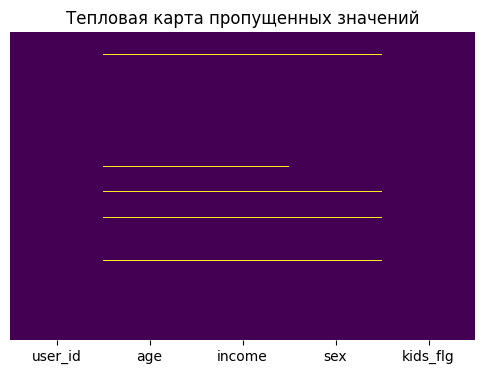

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(users.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [12]:
missing_percentage_users = users.isnull().mean() * 100

# Форматируем вывод
print("Процент пропущенных значений в каждой колонке:")
print(missing_percentage_users)

Процент пропущенных значений в каждой колонке:
user_id     0.000000
age         1.677583
income      1.758635
sex         1.646162
kids_flg    0.000000
dtype: float64


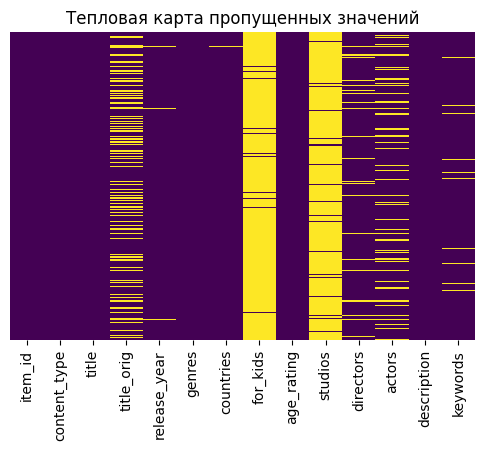

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(items.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [14]:
missing_percentage_items = items.isnull().mean() * 100

# Форматируем вывод
print("Процент пропущенных значений в каждой колонке:")
print(missing_percentage_items)

Процент пропущенных значений в каждой колонке:
item_id          0.000000
content_type     0.000000
title            0.000000
title_orig      29.724989
release_year     0.613920
genres           0.000000
countries        0.231786
for_kids        96.454301
age_rating       0.012529
studios         93.328322
directors        9.453110
actors          16.406690
description      0.012529
keywords         2.649878
dtype: float64


In [15]:
interactions.shape,items.shape,users.shape

((288999, 5), (15963, 14), (840197, 5))

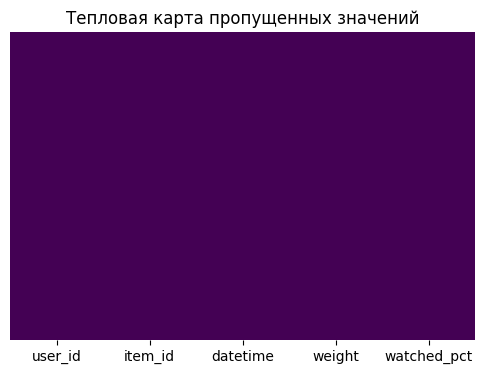

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Создаем тепловую карту пропусков с использованием seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(interactions.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Тепловая карта пропущенных значений")
plt.show()

In [17]:
# 1) Привести колонку к datetime (обязательно, если там строки)
interactions['datetime'] = pd.to_datetime(interactions['datetime'], errors='coerce')
max_date = interactions['datetime'].max()

train = interactions[(interactions['datetime'] <= max_date - pd.Timedelta(days=7))]
test = interactions[(interactions['datetime'] > max_date - pd.Timedelta(days=7))]

# оставляем только теплых пользователей в тесте
test = test[test['user_id'].isin(train['user_id'].unique())]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (266256, 5)
test: (16691, 5)


In [18]:
from rectools.dataset import Dataset

interactions_dataset = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=None
)

In [19]:
# 1. Создаем PopularModel
pop_model = PopularModel(popularity='n_interactions') #popularity='n_interactions'
pop_model.fit(interactions_dataset)

In [20]:
# Предсказание топ 5 предметов для пользователя
user_id = [1]  # Пример ID пользователя
popular_items = pop_model.recommend(user_id, interactions_dataset,filter_viewed=False, k=10)
popular_items

,user_id,item_id,score,rank
0,1,10440,9944.0,1
1,1,15297,9462.0,2
2,1,9728,6259.0,3
3,1,13865,6151.0,4
4,1,4151,4455.0,5
5,1,3734,3594.0,6
6,1,2657,3458.0,7
7,1,4880,2834.0,8
8,1,142,2087.0,9
9,1,6809,2051.0,10


In [21]:
pop_model.get_params()

{'cls': rectools.models.popular.PopularModel,
 'verbose': 0,
 'popularity': <Popularity.N_INTERACTIONS: 'n_interactions'>,
 'period': None,
 'begin_from': None,
 'add_cold': False,
 'inverse': False}

In [22]:
# Найти предметы с наибольшим score
# Сначала отсортируем по колонке 'score' в порядке убывания
highest_scored_items = popular_items.sort_values(by="score", ascending=False)

# Выведем предметы с максимальным score (весь список или, например, топ-1)
top_item = highest_scored_items.head(10)  # Для случая, когда нужен только один самый лучший предмет
print("Товар с наивысшим score:\n", top_item)

Товар с наивысшим score:
    user_id  item_id   score  rank
0        1    10440  9944.0     1
1        1    15297  9462.0     2
2        1     9728  6259.0     3
3        1    13865  6151.0     4
4        1     4151  4455.0     5
5        1     3734  3594.0     6
6        1     2657  3458.0     7
7        1     4880  2834.0     8
8        1      142  2087.0     9
9        1     6809  2051.0    10


In [23]:
pop_recs_1 = popular_items.merge(items[['item_id', 'title']],
                           on='item_id',
                           how='left')
pop_recs_1

,user_id,item_id,score,rank,title
0,1,10440,9944.0,1,Хрустальный
1,1,15297,9462.0,2,Клиника счастья
2,1,9728,6259.0,3,Гнев человеческий
3,1,13865,6151.0,4,Девятаев
4,1,4151,4455.0,5,Секреты семейной жизни
5,1,3734,3594.0,6,Прабабушка легкого поведения
6,1,2657,3458.0,7,Подслушано
7,1,4880,2834.0,8,Афера
8,1,142,2087.0,9,Маша
9,1,6809,2051.0,10,Дуров


In [24]:
pop_recs = pop_model.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

pop_recs = pop_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
pop_recs.head(10)

,user_id,item_id,score,rank,title
0,73094,10440,9944.0,1,Хрустальный
1,73094,15297,9462.0,2,Клиника счастья
2,73094,9728,6259.0,3,Гнев человеческий
3,73094,13865,6151.0,4,Девятаев
4,73094,4151,4455.0,5,Секреты семейной жизни
5,73094,3734,3594.0,6,Прабабушка легкого поведения
6,73094,2657,3458.0,7,Подслушано
7,73094,4880,2834.0,8,Афера
8,73094,142,2087.0,9,Маша
9,73094,6809,2051.0,10,Дуров


In [25]:
# популярность признаку genres
items["genre"] = items["genres"].str.split(",")
items[["genre", "genres","item_id"]].head()

,genre,genres,item_id
0,"[драмы, зарубежные, детективы, мелодрамы]","драмы, зарубежные, детективы, мелодрамы",10711
1,"[зарубежные, приключения, комедии]","зарубежные, приключения, комедии",2508
2,"[криминал, зарубежные, триллеры, боевики, ...","криминал, зарубежные, триллеры, боевики, комедии",10716
3,"[драмы, зарубежные, мелодрамы]","драмы, зарубежные, мелодрамы",7868
4,"[драмы, спорт, советские, мелодрамы]","драмы, спорт, советские, мелодрамы",16268


In [26]:
# делаем flatten представление фичи жанров
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature
genre_feature["feature"] = "genre"
genre_feature.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [27]:
genre_feature = genre_feature[genre_feature['id'].isin(train['item_id'])]
genre_feature

,id,value,feature
7,11114,для детей,genre
7,11114,сказки,genre
7,11114,полнометражные,genre
7,11114,зарубежные,genre
7,11114,семейное,genre
...,...,...,...
15960,10632,криминал,genre
15961,4538,драмы,genre
15961,4538,спорт,genre
15961,4538,криминал,genre


In [28]:
dataset_feature_pop = Dataset.construct(
    interactions_df=train,
    user_features_df=None,
    item_features_df=genre_feature,
    cat_item_features=['genre']
)

In [29]:
from rectools.models.popular_in_category import PopularInCategoryModel

pop_cat = PopularInCategoryModel(category_feature='genre', n_categories=5)
pop_cat.fit(dataset_feature_pop);

In [30]:
pop_recs_cat = pop_cat.recommend(
    test.user_id.unique(),
    dataset=dataset_feature_pop,
    k=10,
    filter_viewed=False
)

In [31]:
pop_recs_cat = pop_recs_cat.merge(items[['item_id', 'title']],
                                   on='item_id',
                                   how='left')

pop_recs_cat.head(10)

,user_id,item_id,score,rank,title
0,896751,15297,9462.0,1,Клиника счастья
1,896751,9728,6259.0,2,Гнев человеческий
2,896751,12192,1675.0,3,Фемида видит
3,896751,7829,987.0,4,Поступь хаоса
4,896751,849,721.0,5,Дебошир
5,896751,13865,6151.0,6,Девятаев
6,896751,7571,1372.0,7,100% волк
7,896751,2657,3458.0,8,Подслушано
8,896751,1844,1316.0,9,Аферистка
9,896751,142,2087.0,10,Маша


In [32]:
# model_ease = EASEModel(regularization=500)
# model_ease.fit(interactions_dataset);

In [33]:
# ease_recs = model_ease.recommend(
#     test.user_id.unique(),
#     dataset=interactions_dataset,
#     k=10,
#     filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
# )

# ease_recs = ease_recs.merge(items[['item_id', 'title']],
#                                on='item_id',
#                                how='left')
# ease_recs.head(10)

In [34]:
model_iALS = ImplicitALSWrapperModel(
    AlternatingLeastSquares(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    ),
    fit_features_together=False,  # way to fit paired features
)
model_iALS.fit(interactions_dataset);

/usr/local/lib/python3.12/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [35]:
model_iALS.get_config()

{'cls': rectools.models.implicit_als.ImplicitALSWrapperModel,
 'verbose': 0,
 'model': {'cls': 'AlternatingLeastSquares',
  'factors': 10,
  'regularization': 0.1,
  'alpha': 50.0,
  'dtype': dtype('float32'),
  'use_native': True,
  'use_cg': True,
  'use_gpu': False,
  'iterations': 10,
  'calculate_training_loss': False,
  'num_threads': 0,
  'random_state': 42},
 'fit_features_together': False,
 'recommend_n_threads': None,
 'recommend_use_gpu_ranking': None}

In [36]:
iALS_recs = model_iALS.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs = iALS_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs.head(10)

,user_id,item_id,score,rank,title
0,73094,11654,0.283598,1,Три богатыря. На дальних берегах
1,73094,12228,0.282334,2,Волк с Уолл-стрит
2,73094,7793,0.277255,3,Радиовспышка
3,73094,6006,0.274855,4,Кости
4,73094,4266,0.269764,5,Киви и Стрит
5,73094,14431,0.269035,6,Приворот. Чёрное венчание
6,73094,9254,0.268987,7,Покушение
7,73094,3071,0.268154,8,Родные
8,73094,9937,0.268020,9,12 лет рабства
9,73094,4702,0.267979,10,Хищник


In [37]:
model_iALS_Bpr = ImplicitBPRWrapperModel(
     BayesianPersonalizedRanking(
        factors=10,  # latent embeddings size
        regularization=0.1,
        iterations=10,
        # alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=42,
    )
    # fit_features_together=False,  # way to fit paired features
)
model_iALS_Bpr.fit(interactions_dataset);

In [38]:
iALS_recs_BPR = model_iALS_Bpr.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

iALS_recs_BPR  = iALS_recs_BPR.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
iALS_recs_BPR.head(10)

,user_id,item_id,score,rank,title
0,73094,9728,0.236552,1,Гнев человеческий
1,73094,15363,0.168152,2,Крик 4
2,73094,4151,0.167560,3,Секреты семейной жизни
3,73094,10440,0.162377,4,Хрустальный
4,73094,15297,0.156981,5,Клиника счастья
5,73094,2362,0.153484,6,Неудобные вопросы
6,73094,13610,0.153373,7,Полночь в Париже
7,73094,13248,0.150446,8,Ёлки 5
8,73094,14362,0.147992,9,Заложница
9,73094,3734,0.146400,10,Прабабушка легкого поведения


In [42]:
model_LightFM = LightFMWrapperModel(
     LightFM(
        no_components=10,
        loss="warp",
        random_state=42,
    )

)
model_LightFM.fit(interactions_dataset);

In [43]:
LightFM_recs= model_LightFM.recommend(
    test.user_id.unique(),
    dataset=interactions_dataset,
    k=10,
    filter_viewed=False  # True - удаляет просмотренные айтемы из рекомендаций
)

LightFM_recs = LightFM_recs.merge(items[['item_id', 'title']],
                               on='item_id',
                               how='left')
LightFM_recs.head(10)

,user_id,item_id,score,rank,title
0,73094,10440,2.802020,1,Хрустальный
1,73094,15297,2.783514,2,Клиника счастья
2,73094,9728,2.595882,3,Гнев человеческий
3,73094,13865,2.569238,4,Девятаев
4,73094,4151,2.457518,5,Секреты семейной жизни
5,73094,3734,2.407714,6,Прабабушка легкого поведения
6,73094,2657,2.395981,7,Подслушано
7,73094,4880,2.304735,8,Афера
8,73094,142,2.217672,9,Маша
9,73094,6809,2.214735,10,Дуров


In [44]:
from rectools.metrics import (calc_metrics, MeanInvUserFreq,
                              AvgRecPopularity, MAP, NDCG, CoveredUsers,HitRate,
                              CatalogCoverage,Intersection,Serendipity)

recs = {
    "pop": pop_recs,
    "pop_cat": pop_recs_cat,
    # "ease_recs": ease_recs,
    'iALS_recs':iALS_recs,
    'iALS_recs_BPR': iALS_recs_BPR,
    'LightFM_recs':LightFM_recs
}

metrics= {
    'map@10': MAP(k=10), # качество ранжирования
    "novelty": MeanInvUserFreq(k=10), # глобальная новизна
    "arp": AvgRecPopularity(k=10),  # popularity bias
    "ndcg": NDCG(k=10),
    "covarege": CoveredUsers(k=10),
    "hitrate": HitRate(k=10),
    "Intersection":Intersection(k=10),
    "Serendipity@10": Serendipity(k=10)

}

metrics_dict = {}
for model_name, recs_1 in recs.items():
    metrics_dict[model_name] = calc_metrics(
        metrics=metrics,
        reco=recs_1,
        interactions=test,
        prev_interactions=train,
        catalog=train['user_id'].unique(),
        # ref_reco=["popular"]
        ref_reco = {"same_model": recs_1}
    )


pd.DataFrame(metrics_dict).T

,hitrate,ndcg,map@10,novelty,arp,Serendipity@10,Intersection_same_model,covarege
pop,0.250861,0.036609,0.066387,3.438401,5029.500000,0.000000e+00,1.0,1.0
pop_cat,0.221916,0.032470,0.062214,4.313222,3348.800000,2.234272e-06,1.0,1.0
iALS_recs,0.030324,0.003239,0.005622,9.610396,262.080393,4.074432e-06,1.0,1.0
iALS_recs_BPR,0.206926,0.028760,0.049662,6.760677,3394.860751,2.441007e-06,1.0,1.0
LightFM_recs,0.252412,0.036769,0.066681,3.449796,5014.238370,8.839198e-08,1.0,1.0


In [45]:
def leave_top_k(reco, k):
    # Функция для выбора топ-K рекомендаций
    return reco[reco['rank'] <= k]

def coverage(reco, k, interactions, catalog):


    # Оставляем только топ-K рекомендации
    pred_to_consider = set(leave_top_k(reco, k)['item_id'].values)

    # Преобразуем полный каталог в множество
    all_items = set(catalog)

    # Вычисляем Coverage@K
    coverage_score = len(pred_to_consider & all_items) / len(all_items)
    return coverage_score


# Построим результаты Coverage@K для двух моделей
k = 10 # Задаем значение K
for model_name, model_recs in recs.items():

    cov_score = coverage(model_recs, k, None, train['user_id'].unique())
    print(f"Coverage@{k} для модели {model_name}: {cov_score:.2%}")

Coverage@10 для модели pop: 0.00%
Coverage@10 для модели pop_cat: 0.00%
Coverage@10 для модели iALS_recs: 0.15%
Coverage@10 для модели iALS_recs_BPR: 0.00%
Coverage@10 для модели LightFM_recs: 0.00%


In [51]:
import pandas as pd
import plotly.express as px
import re
from rectools.metrics import (
    calc_metrics, MeanInvUserFreq, AvgRecPopularity, MAP, NDCG, CoveredUsers,
    HitRate, CatalogCoverage, Intersection, Serendipity
)

# Рекомендации от разных моделей
recs = {
    "pop": pop_recs,
    "pop_cat": pop_recs_cat,
    # "ease_recs": ease_recs,
    "iALS_recs": iALS_recs,
    'iALS_recs_BPR': iALS_recs_BPR,
    'LightFM_recs':LightFM_recs
}

# Метрики
metrics = {
    "MAP@10": MAP(k=10),              # Качество ранжирования
    "Novelty": MeanInvUserFreq(k=10), # Глобальная новизна
    "ARP": AvgRecPopularity(k=10),    # Bias к популярности
    "NDCG@10": NDCG(k=10),            # Нормализованная средневзвешенная кумулятивная прибыль
    "Coverage@10": CoveredUsers(k=10),# Покрытие пользователей
    "HitRate@10": HitRate(k=10),      # Процент пользователей, получивших хотя бы одну релевантную рекомендацию
    "Intersection@10": Intersection(k=10), # Пересечение рекомендаций
    "Serendipity@10": Serendipity(k=10),   # Серендипность рекомендаций
}

# Словарь для хранения результатов метрик
metrics_dict = {}

# Вычисляем метрики для каждой модели
for model_name, recs_model in recs.items():
    metrics_dict[model_name] = calc_metrics(
        metrics=metrics,
        reco=recs_model,
        interactions=test,
        prev_interactions=train,
        catalog=train['user_id'].unique(),
        ref_reco={"same_model": recs_model},
    )

# Преобразуем результат в DataFrame
cv_results = pd.DataFrame(metrics_dict).T

# Группируем результаты, если требуется
pivot_results = cv_results.groupby(level=0).mean()  # Группировка по моделям (уровень 0)
pivot_results.index.name="model"
# Выводим метрики только, которые нужны
models_metrics = pivot_results.reset_index()[["model","MAP@10", "Serendipity@10"]]

# Фильтрация моделей, которые нужно исключить
models_to_skip_meta = ["bert4rec_softmax_ids_and_cat"]


# Сегментация и сортировка (при необходимости)
models_metadata = [
    {
        "model": model_name,
        "item_net_block_types": ",".join(
            block for block in ["Id", "Cat"]
            if re.search(block, str(metrics_dict.get(model_name, {}).get("item_net_block_types", "")))
        ),
    }
    for model_name in recs.keys() if model_name not in models_to_skip_meta
]

# Вывод всех моделей и метрик для визуализации
from rectools.visuals import MetricsApp  # Импорт вашего MetricsApp

app = MetricsApp.construct(
    models_metrics=models_metrics,
    models_metadata=pd.DataFrame(models_metadata),
    scatter_kwargs={
        "color_discrete_sequence": px.colors.qualitative.Dark24,
        "symbol_sequence": ['circle', 'square', 'diamond', 'cross', 'x', 'star', 'pentagon'],
    }
)

fig = app.fig
fig.update_layout(title="Model CV metrics with Serendipity", font={"size": 15})
fig.show()

In [50]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [55]:
import re
import numpy as np
import pandas as pd
from scipy import sparse
from lightfm import LightFM
from lightfm.data import Dataset

import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from lightfm import LightFM
from lightfm.data import Dataset

def simple_tokenize(text: str):
    # Простая токенизация: нижний регистр, латиница/кириллица и цифры, длина >= 2
    text = (text or "").lower()
    tokens = re.findall(r"[a-zA-Zа-яА-ЯёЁ0-9]+", text)
    return [t for t in tokens if len(t) >= 2]

def build_lightfm_inputs(users_df: pd.DataFrame,
                         items_df: pd.DataFrame,
                         interactions_df: pd.DataFrame,
                         user_col="user_id",
                         item_col="item_id",
                         weight_col=None,
                         title_col="title",
                         min_token_df=2,
                         max_vocab=None):
    """
    Строит interactions, weights и item_features (на основе токенов title + identity-фичи).
    """
    # 1) Словари id
    user_ids = users_df[user_col].astype(str).unique().tolist()
    item_ids = items_df[item_col].astype(str).unique().tolist()

    # 2) Токенизация title по всем товарам
    title_tokens_per_item = {}
    df_counts = {}
    for row in items_df[[item_col, title_col]].itertuples(index=False):
        iid = str(getattr(row, item_col))
        title = getattr(row, title_col)
        toks = simple_tokenize(title)
        title_tokens_per_item[iid] = toks
        for t in set(toks):  # document frequency
            df_counts[t] = df_counts.get(t, 0) + 1

    # Отсечем редкие токены и, при необходимости, ограничим размер словаря
    n_items_total = len(item_ids)
    vocab = [t for t, c in df_counts.items() if c >= min_token_df]
    if max_vocab:
        vocab = sorted(vocab, key=lambda t: df_counts[t], reverse=True)[:max_vocab]

    # Имена признаков: префиксуем, чтобы не путать с identity-фичами
    token_features = [f"title={t}" for t in vocab]

    # Identity-фичи для каждого товара (сохраняем коллаборативную компоненту)
    item_identity_features = [f"ITEM_ID={iid}" for iid in item_ids]

    # 3) Готовим Dataset с фичами
    dataset = Dataset()
    dataset.fit(users=user_ids, items=item_ids,
                user_features=[],
                item_features=token_features + item_identity_features)

    # 4) Interactions
    def iter_interactions():
        for row in interactions_df[[user_col, item_col] + ([weight_col] if weight_col else [])].itertuples(index=False):
            u = str(getattr(row, user_col))
            i = str(getattr(row, item_col))
            w = float(getattr(row, weight_col)) if weight_col else 1.0
            yield (u, i, w)

    interactions, weights = dataset.build_interactions(iter_interactions())

    # 5) Item features: для каждого item — токены + своя identity-фича
    def iter_item_features():
        for iid in item_ids:
            toks = title_tokens_per_item.get(iid, [])
            toks = [t for t in toks if t in vocab]
            feats = [f"title={t}" for t in toks]
            feats.append(f"ITEM_ID={iid}")  # identity-фича товара
            yield (iid, feats)

    item_features = dataset.build_item_features(iter_item_features(), normalize=False)

    return dataset, interactions, weights, item_features

# ===== Пример использования =====
# users: DataFrame с колонкой user_id
# items: DataFrame с колонками item_id, title
# interactions: DataFrame с колонками user_id, item_id[, weight]

dataset, interactions, weights, item_features = build_lightfm_inputs(
    users_df=users,
    items_df=items,
    interactions_df=interactions,
    user_col="user_id",
    item_col="item_id",
    weight_col=None,          # или укажите колонку с весом, если есть
    title_col="title",
    min_token_df=2,           # минимальное число товаров, где встречается токен
    max_vocab=20000           # ограничение словаря (по частоте)
)

model = LightFM(no_components=10, loss="warp", random_state=42)
model.fit(interactions,
          sample_weight=weights,
          item_features=item_features,
          epochs=20,
          num_threads=4)

# Прогноз для конкретного пользователя по списку item_ids:
# Нужно использовать внутренние индексы из dataset.mapping()
user_id_map, _, item_id_map, _ = dataset.mapping()
u_internal = user_id_map[str(users.iloc[0]["user_id"])]
item_internal_ids = [item_id_map[str(i)] for i in items["item_id"].astype(str).tolist()]
scores = model.predict(u_internal, item_internal_ids, item_features=item_features, num_threads=4)

TypeError: 'coo_matrix' object is not subscriptable